# Producing rainfall profiles for Lin Dyke
Synthetic summary profiles have been produced for extreme UK rain storms, which describe the intensity of rainfall over time.  
This work tests the extent to which use of these different profiles affects the flooding outcomes.  
The profiles are tested using a 2D Hec-Ras model of the Lin Dyke catchments in east Leeds.  

A 6 hour duration, 100 year return period event is initially focussed on (with the idea that if differences between profiles are identified at this return period then further investigation will be made of whether differences are also present for less rare events). The total rainfall volume associated with a 6hr, 1-in-100 year event in the Lin Dyke catchment  is extracted from ReFH2 (and is 59.98mm).

The Hec-Ras model requires a rainfall input which describes the rainfall depth at each minute during the rain storm event duration. The summary profiles describe the proportion of the total rainfall volume which falls in each of 12 time steps in any event duration. To use these to generate a rainfall input in the required format for a particular cluster:
* Extract the information for just that cluster, for the correct duration bins 
* For each of the 12 time steps, multiply the proportion of rain found in this timestep by the total event rainfall (59.98mm) to get the total rainfall depth which should fall in this time step
* In the case of a 6hr duration event, each of the 12 timesteps is 30 minutes long. The total rainfall depth falling in that 30 minute period is assumed to fall at a constant rate during that 30 minute interval. And so each minute within the interval is assigned a rainfall depth of 1/30th of the time step total
* The cumulative rainfall depth at each minute, and rainfall rate in each minute is also calculated

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import math
from matplotlib import dates as mdates
import matplotlib.patches as mpatches
import sys
sys.path.insert(1, '../')

from Functions import *

# Read in data needed to produce synthetic summary profiles
### Define total event rainfall for 6h duration, 100 year return period event in Lin Dyke

In [2]:
total_event_rainfall = 59.98
total_duration_minutes = 60* 6 

### Read in synthetic summary profiles

In [3]:
# Read in profiles
profiles = pd.read_csv("kmeans_15clustersPerDur.csv")
# Just keep prain (proportion of rainfall in each timestep)
profiles = profiles[profiles['Variable'] == 'prain']

# Produce synthetic profiles for Lin Dyke Catchment
## Calculate the rainfall depth in each minute for each of 15 clusters
In the case of a 6hr duration event, each of the 12 timesteps is 30 minutes long. The total rainfall depth falling in that 30 minute period is assumed to fall at a constant rate during that 30 minute interval. And so each minute within the interval is assigned a rainfall depth of 1/30th of the time step total.

##### Test for one cluster

In [4]:
one_cluster = get_one_cluster_one_variable(profiles, 9,'[2:10 - 6:45) hr' )
one_cluster = find_rainfall_depth_each_min(one_cluster, 59.98 )
one_cluster = add_cumulative_values(one_cluster)
one_cluster.head()

,minute,rainfall_depth_this_min,cumulative_rainfall_this_min,rainfall_rate
0,1,0.078433,0.078433,4.705973
1,2,0.078433,0.156866,4.705973
2,3,0.078433,0.235299,4.705973
3,4,0.078433,0.313732,4.705973
4,5,0.078433,0.392164,4.705973


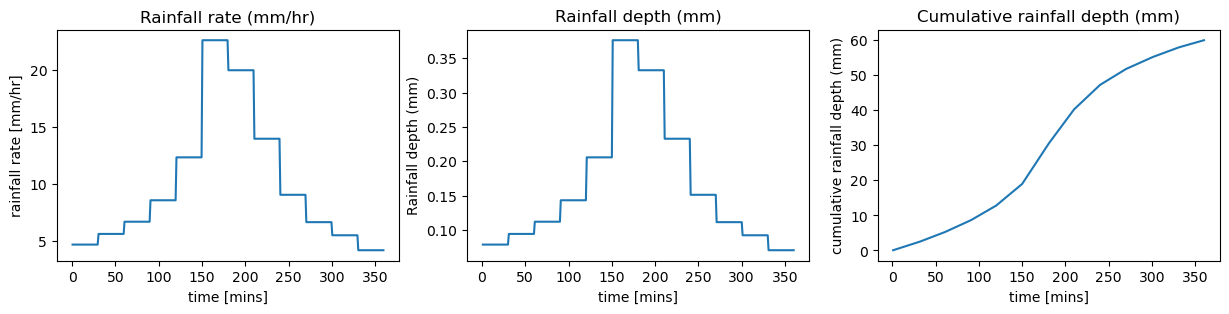

In [5]:
plot_rainfall_depth_each_min(one_cluster)

##### Produce similar outputs for each of the 15 clusters for a 6hr duration event

In [6]:
start = datetime(2022,8,1,0,0,0)
end = start + relativedelta(hours=int(total_duration_minutes/60)) - timedelta(minutes=1)
seconds = (end - start).total_seconds() + 60
step = timedelta(minutes=1)
datetimes = []
for i in range(0, int(seconds), int(step.total_seconds())):
    datetimes.append(start + timedelta(seconds=i))      

In [7]:
# Create a list of formatted dates to apply to dataframe instead of minute numbers
firstdate= datetime(2022, 8, 1, 0, 0)
dates = []
for minute in range(1,361):
    firstdate += timedelta(minutes=1)
    dates.append(firstdate)

clusters_rainfall_data_ls = []    
for cluster_number in range(1,16):
    # Get the data for just this cluster, for the relevant duration
    one_cluster = get_one_cluster_one_variable(profiles, cluster_number,'[2:10 - 6:45) hr' )
    # Find the rainfall depth associated with each minute
    one_cluster = find_rainfall_depth_each_min(one_cluster, 59.98)
    # Add the cumulative totals
    one_cluster = add_cumulative_values(one_cluster)
    #  Add to list
    clusters_rainfall_data_ls.append(one_cluster)
    
    # Add a formatted date column
    start = datetime(2022,8,1,0,0,0)
    end = start + relativedelta(hours=int(total_duration_minutes/60)) - timedelta(minutes=1)
    seconds = (end - start).total_seconds() + 60
    step = timedelta(minutes=1)
    datetimes = []
    for i in range(0, int(seconds), int(step.total_seconds())):
        datetimes.append(start + timedelta(seconds=i))      
    # Keep just the columns needed for ReFH2
    one_cluster = one_cluster[['minute', 'rainfall_depth_this_min']].copy()
    one_cluster.to_csv("6hr_100yrRP/PreLossRemoval/cluster{}.csv".format(cluster_number),  index = False, header=False) 
    
    # Convert back to dates for ReFH2
    one_cluster['minute'] = datetimes
    # Save to file (without column headers)
    one_cluster.to_csv("6hr_100yrRP/PreLossRemoval/cluster{}_formatteddates.csv".format(cluster_number), index = False, header = False)    

# Create a single peaked profile equivalent to the FEH profile
### Find the accumulation/rate associated with each minute in a 6h profile 

In [9]:
# Paramters (altho these all relate to multiple peaks think we still have to specify) 
N_subpeaks= 3
total_duration_minutes= 6 * 60
subpeak_duration_minutes=total_duration_minutes/6
# Find accumulation and rate
accum, rate= calc_rainfall_curves('single-peak',total_event_rainfall,total_duration_minutes,N_subpeaks,subpeak_duration_minutes)
# Construct as dataframe
df = pd.DataFrame({"minute": np.array(range(total_duration_minutes)),
                   'rainfall_rate':rate,
                   'rainfall_depth_this_min':rate/60,
                   'cumulative_rainfall_this_min': accum[1:]})   

### Plot the rainfall rate, depth and accumulations

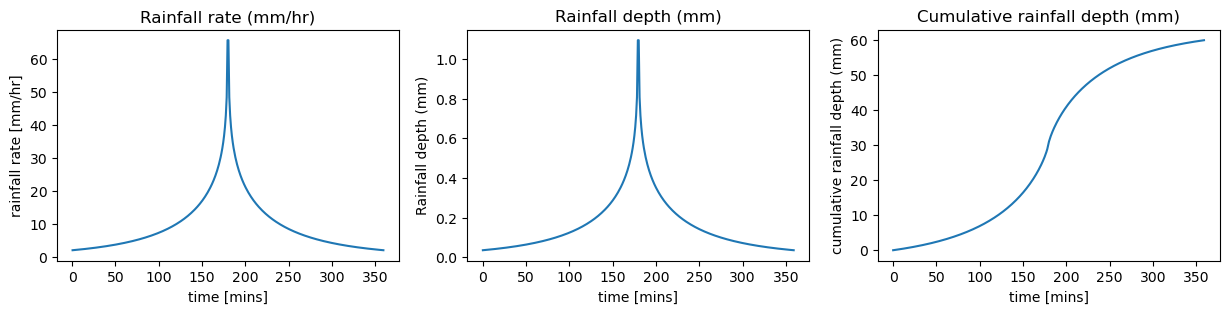

In [10]:
plot_rainfall_depth_each_min(df)

# Plot rainfall depth in each minute for each of the 15 clusters + FEH single-peak profile

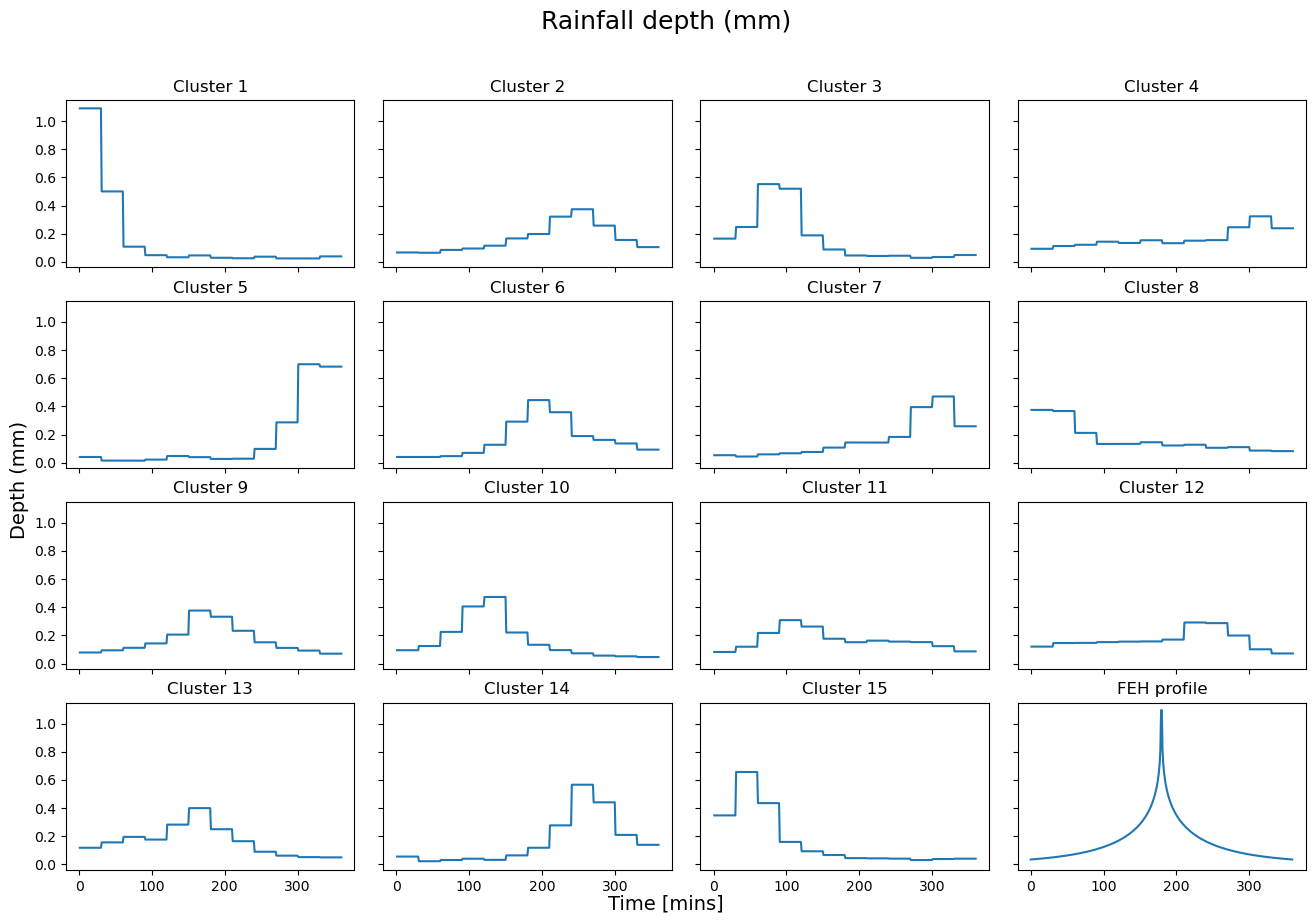

In [11]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize =(16,10), sharey=True, sharex = True)
plt.subplots_adjust(wspace=0.1)
fig.suptitle("Rainfall depth (mm)", fontsize=18, y=0.97)

clusters_and_feh_ls = clusters_rainfall_data_ls.copy()
clusters_and_feh_ls.insert(0, df)

# loop through tickers and axes
for num, clusters_rainfall_data in enumerate(clusters_and_feh_ls):
    ax = axs.ravel()[num-1]
    ax.plot(clusters_rainfall_data['minute'], clusters_rainfall_data['rainfall_depth_this_min'])   
    if num == 0:
        ax.set_title("FEH profile")
    else:
        ax.set_title("Cluster {}".format(num))
fig.text(0.5, 0.07, 'Time [mins]', ha='center', fontsize =14)
fig.text(0.09, 0.5, "Depth (mm)", va='center', rotation='vertical', fontsize =14);

In [12]:
max_vals = []
for i in range(0,len(clusters_and_feh_ls)):
    max_vals.append(max(clusters_and_feh_ls[i]['rainfall_depth_this_min']))
    
max_vals_df =pd.DataFrame({'cluster': list(range(0,16)), 'max_val': max_vals})
max_vals_df.sort_values('max_val', ascending = False)

,cluster,max_val
0,0,1.095628
1,1,1.090310
5,5,0.699399
15,15,0.656646
14,14,0.566253
3,3,0.551903
10,10,0.473021
7,7,0.470425
6,6,0.444581
13,13,0.399892


# Plot the cumulative rainfall depth for all profiles + FEH profile

In [41]:
# cluster_results= pd.read_csv("../../ProcessModelResults/ObservedProfiles/Data/allclusters_summary.csv")
cluster_results[cluster_results['Cluster_num']=='6h_c{}'.format(cluster_number)]['colour'].values[0]

'darkblue'

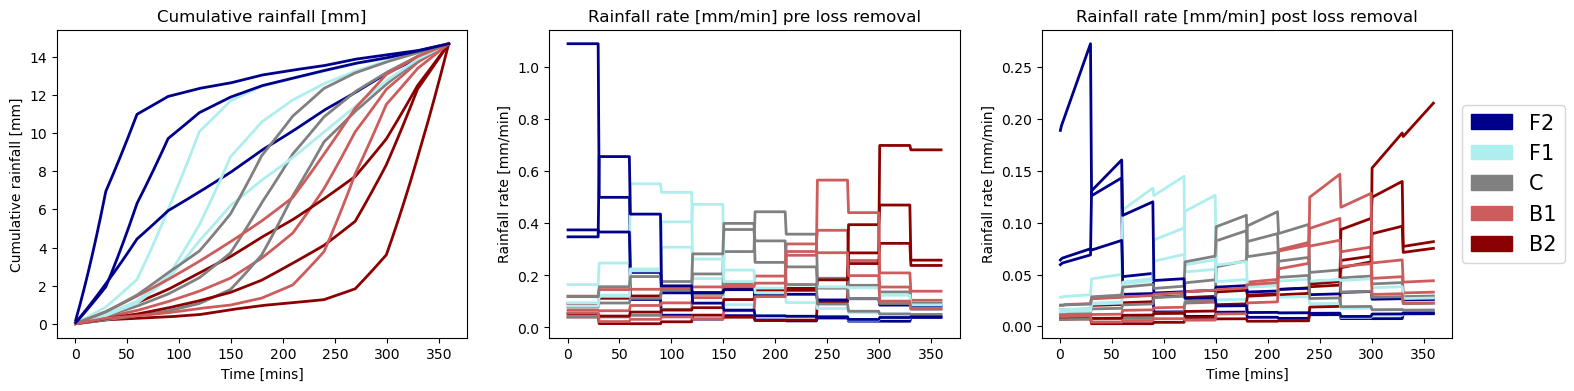

In [42]:
fig, axes = plt.subplots(1, 3,figsize=(18,4), sharex =True, sharey = False)
colors = ['darkblue']*3 + ['paleturquoise']*3 + ['grey']*3+ ['indianred']*3+['darkred']*3
for cluster_number in range(1,16):
    cluster_color = cluster_results[cluster_results['Cluster_num']=='6h_c{}'.format(cluster_number)]['colour'].values[0]
    # Read in pre and post loss removal data
    pre_loss_removal = pd.read_csv('../ObservedProfiles/' + "6hr_100yrRP/PreLossRemoval/cluster{}.csv".format(cluster_number), names = ['Time', 'Rainfall'])
    post_loss_removal = pd.read_csv('../ObservedProfiles/' + "6hr_100yrRP/PostLossRemoval/cluster{}_urban_summer.csv".format(cluster_number))
    # Reformat (time columne)
    post_loss_removal = clean_dfs(post_loss_removal)
    post_loss_removal['cumulative_rainfall_this_min'] = post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'].cumsum()
    # Plot cumulative rainfall rate
    axes[0].plot(np.array(range(360))+0.5,post_loss_removal['cumulative_rainfall_this_min'], color=cluster_color, linewidth = 2)   
    axes[0].set_xlabel('Time [mins]')
    axes[0].set_ylabel('Cumulative rainfall [mm]')
    axes[0].set_title('Cumulative rainfall [mm]')
    
    # Plot pre loss removal rainfall rate
    axes[1].plot(np.array(range(360))+0.5,pre_loss_removal['Rainfall'], color=cluster_color, linewidth = 2)   
    axes[1].set_ylabel('Rainfall rate [mm/min]')
    axes[1].set_title('Rainfall rate [mm/min] pre loss removal')
    
    # Plot post loss removal rainfall rate
    axes[2].plot(np.array(range(360))+0.5,post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'], color=cluster_color, linewidth = 2)   
    axes[2].set_xlabel('Time [mins]')
    axes[2].set_ylabel('Rainfall rate [mm/min]')
    axes[2].set_title('Rainfall rate [mm/min] post loss removal')
    
colors_leg = ['darkblue', 'paleturquoise', 'grey', 'indianred', 'darkred']
texts = ['F2','F1','C', 'B1', 'B2'] 
patches = [ mpatches.Patch(color=colors_leg[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.15, 0.5), loc='center', ncol=1, prop={'size': 15} );    